# Setup

In [1]:
import optuna
import densenet
from tensorflow.keras import optimizers
import tensorflow as tf
import numpy as np
from util import evaluate, load_data, create_class_weights, plot_history
from hyperparam_optimization import gaussian_peak
import dataloader

2024-07-25 14:56:19.225995: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-25 14:56:19.240018: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-25 14:56:19.244275: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-25 14:56:19.255137: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-25 14:56:19.933058: W tensorflow/comp

In [2]:
input_shape = (48, 48, 1)
train_dir = "dataset/train"
test_dir = "dataset/test"
classes = sorted(["angry", "disgust", "fear", "happy", "sad", "surprise", "neutral"])
greyscale = True
augmentation = None
train_ds, test_ds = dataloader.load(
    train_dir, test_dir, 7, OneChannelOnly=greyscale, augmentations=augmentation
)
_, _, y_train_encoded = load_data(train_dir, classes, greyscale=greyscale)
class_weights_dict = create_class_weights(y_train_encoded)

# Load test data
x_test, y_test, y_test_encoded = load_data(test_dir, classes, greyscale=greyscale)

Found 29535 files belonging to 7 classes.


2024-07-25 14:56:23.786479: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22760 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:17:00.0, compute capability: 7.5
2024-07-25 14:56:23.788068: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22752 MB memory:  -> device: 1, name: Quadro RTX 6000, pci bus id: 0000:65:00.0, compute capability: 7.5


Found 6990 files belonging to 7 classes.


## Load study (optuna.db)

In [3]:
study = optuna.create_study(
    direction="minimize",
    study_name="custom-densenet",
    storage=f"sqlite:///optuna.db",
    load_if_exists=True,
)
trial = study.best_trial

[I 2024-07-25 14:56:28,167] Using an existing study with name 'custom-densenet' instead of creating a new one.


## Create Model with Optimal parameters

In [4]:
def densenet_args_from_trial(trial):
    num_layers_per_block = gaussian_peak(trial.params["min_layers"], trial.params["max_layers"], trial.params["num_blocks"])
    args = dict(
        input_shape=input_shape,
        num_blocks=trial.params["num_blocks"],
        num_layers_per_block=num_layers_per_block,
        growth_rate=trial.params["growth_rate"],
        reduction=trial.params["reduction"],
        num_classes=len(classes),
        dropout_rate=trial.params["dropout_rate"],
        l2_regularization=trial.params["l2_regularization"],
    )
    return args


args = densenet_args_from_trial(trial)

In [5]:
model = densenet.DenseNet(**args)
model.build((None, *input_shape))
model.compile(
    optimizer=optimizers.Adam(),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
# Callback functions
metric = "val_accuracy"
mode = "max"
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor=metric, patience=10, restore_best_weights=True, mode=mode
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor=metric, factor=0.5, patience=5, min_lr=1e-7, mode=mode
)

/data/hagemann/ml/venv/lib64/python3.9/site-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'dense_net', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


In [8]:
model.summary()

Model: "dense_net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 24, 24, 32)     │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 24, 24, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_block_1 (DenseBlock)      │ ?                      │        53,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transition_layer_1              │ ?                      │        16,320 │
│ (TransitionLayer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_block_2 (DenseBlock)      │ ?                      │       743,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transition_layer_2              │ ?                      │       424,438 │
│ (TransitionLayer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_block_3 (DenseBlock)      │ ?                      │       159,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_69          │ (None, 3, 3, 974)      │         3,896 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_69 (ReLU)                 │ (None, 3, 3, 974)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 974)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │         6,825 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,171,799 (15.91 MB)

 Trainable params: 1,381,475 (5.27 MB)

 Non-trainable params: 27,372 (106.92 KB)

 Optimizer params: 2,762,952 (10.54 MB)

## Training & Evaluation

In [6]:
history = model.fit(
    train_ds,
    class_weight=class_weights_dict,
    epochs=100,
    validation_data=test_ds,
    callbacks=[reduce_lr, early_stopping],
)

Epoch 1/100


I0000 00:00:1721912206.409030 1891966 service.cc:146] XLA service 0x7f6eb400aa80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1721912206.409075 1891966 service.cc:154]   StreamExecutor device (0): Quadro RTX 6000, Compute Capability 7.5
I0000 00:00:1721912206.409087 1891966 service.cc:154]   StreamExecutor device (1): Quadro RTX 6000, Compute Capability 7.5
2024-07-25 14:56:47.051888: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-25 14:56:49.540889: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8902


  5/110 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.0821 - loss: 2.0287   

I0000 00:00:1721912228.776911 1891966 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


110/110 ━━━━━━━━━━━━━━━━━━━━ 81s 371ms/step - accuracy: 0.1239 - loss: 1.9503 - val_accuracy: 0.1718 - val_loss: 1.9173 - learning_rate: 0.0010
Epoch 2/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step - accuracy: 0.1738 - loss: 1.9447 - val_accuracy: 0.1521 - val_loss: 1.9301 - learning_rate: 0.0010
Epoch 3/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step - accuracy: 0.1700 - loss: 1.9295 - val_accuracy: 0.1784 - val_loss: 1.8938 - learning_rate: 0.0010
Epoch 4/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - accuracy: 0.1762 - loss: 1.9174 - val_accuracy: 0.1855 - val_loss: 1.9120 - learning_rate: 0.0010
Epoch 5/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - accuracy: 0.2170 - loss: 1.9061 - val_accuracy: 0.2478 - val_loss: 1.8881 - learning_rate: 0.0010
Epoch 6/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - accuracy: 0.2148 - loss: 1.9223 - val_accuracy: 0.2236 - val_loss: 1.8974 - learning_rate: 0.0010
Epoch 7/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 8s 74ms/step - accuracy: 0.2070 - loss: 1.913

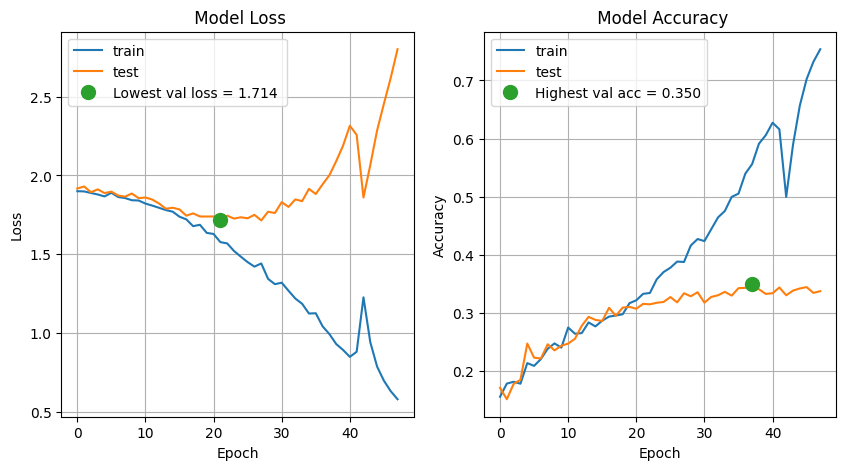

219/219 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - accuracy: 0.4616 - loss: 1.3075
[1.1114336252212524, 0.5738197565078735]
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.27      0.36       939
           1       0.85      0.93      0.89        84
           2       0.48      0.35      0.41       982
           3       0.62      0.81      0.71      1850
           4       0.51      0.53      0.52      1255
           5       0.53      0.54      0.54      1270
           6       0.68      0.79      0.73       610

    accuracy                           0.57      6990
   macro avg       0.60      0.60      0.59      6990
weighted avg       0.56      0.57      0.56      6990

Confusion Matrix:
 [[ 249    5  115  220  161  151   38]
 [   1   78    1    0    1    3    0]
 [  62    0  348  181  133  178   80]
 [  48    3   57 1503  111   90   38]
 [  40    2   61  278  664  166   44]
 [  49    

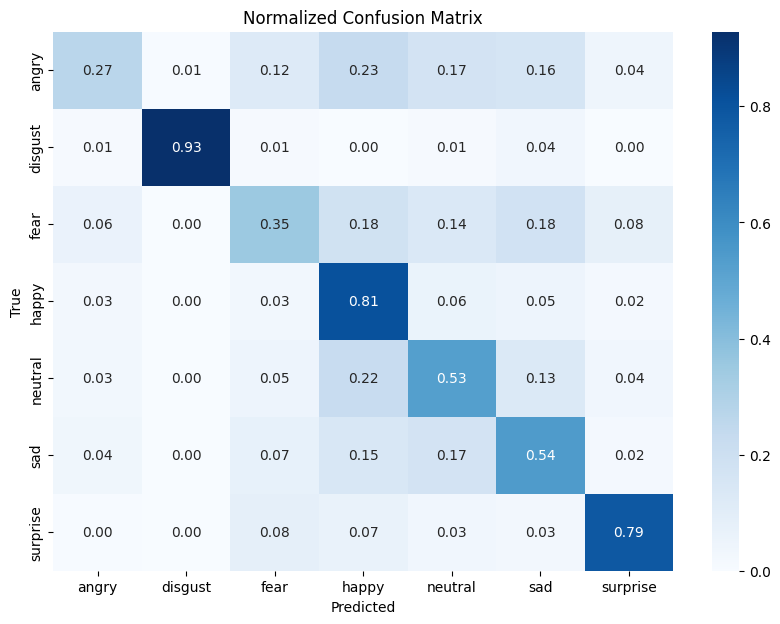

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


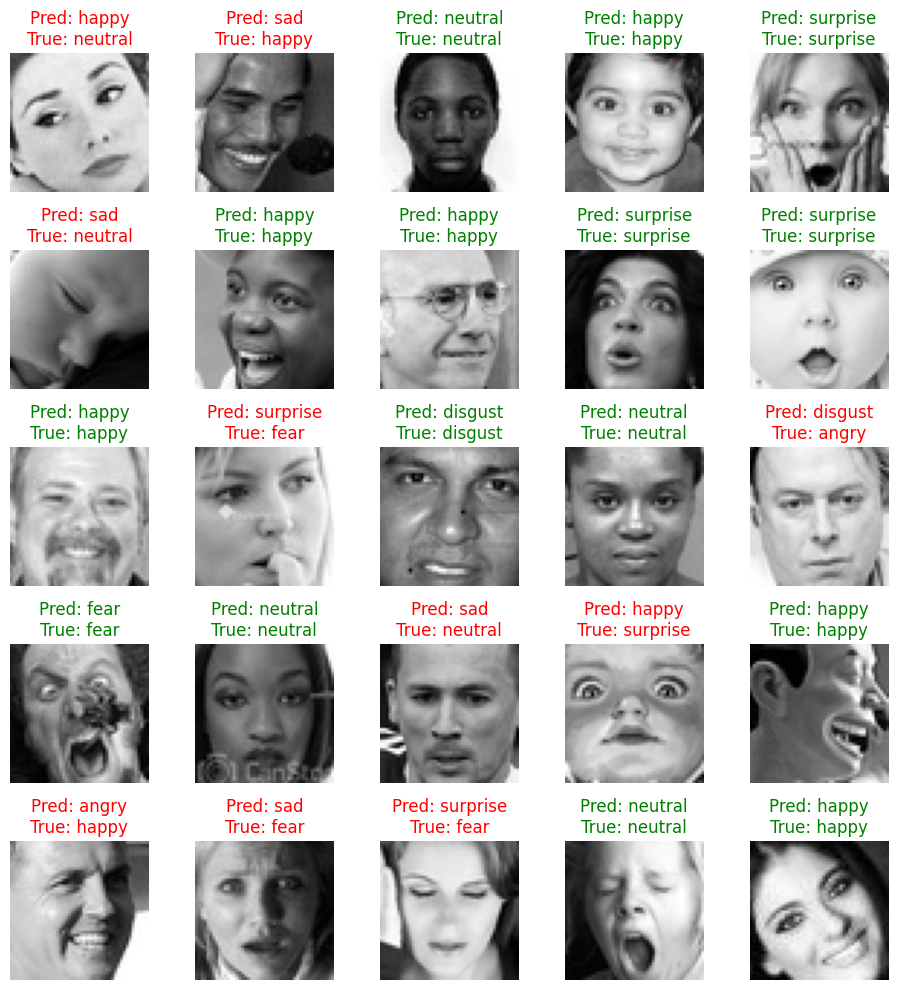

219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4616 - loss: 1.3075


In [7]:
plot_history(history)
evaluate(model, x_test, y_test, y_test_encoded, classes)
# return loss (necessary)
loss, accuracy = model.evaluate(x_test, y_test_encoded)